# Constants

In [1]:
WEIGHTS_FILE = "calc.caffemodel.pt"
DATASET = "GardensPoint"
DATABASE_FOLDER = "day_right"
QUERY_FOLDER = "night_right"
ITERATIONS = 50 # for testing average duration
BATCH_SIZE = 32 # dataloader batch_size
NUM_WORKERS = 8 # dataloader num_workers (threads)
DATA_TEXT_FILE = 'data_laptop.txt' # save the average database and query times to this file

# Imports

In [2]:
# Uncomment these lines to install the necessary packages
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install opencv-python numpy seaborn matplotlib scikit-learn ipykernel tqdm pillow
# %pip install onnx onnxruntime

In [3]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import seaborn as sns
import onnx
import onnxruntime
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime.quantization.shape_inference import quant_pre_process
from onnxruntime.quantization.calibrate import CalibrationDataReader
from onnxruntime.quantization import quantize_static
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

from datasets import dataset_utils
from matching import matching
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from datasets.load_dataset import GardensPointDataset, SFUDataset, StLuciaDataset

# Load Dataset

In [4]:
# Uncomment to download the desired chosen dataset to the images folder
# GardensPointDataset().load()
# SFUDataset().load()
# StLuciaDataset().load()

# Uncomment this line if using GardensPoint
_, _, gt_hard, gt_soft = GardensPointDataset().load()

# Uncomment these lines if using SFU or StLucia
# gt_data = np.load(f'images/{DATASET}/GT.npz')
# gt_hard = gt_data['GThard']
# gt_soft = gt_data['GTsoft']

===== Load dataset GardensPoint day_right--night_right


# Preprocess Images

In [5]:
class ConvertToYUVandEqualizeHist:
    def __call__(self, img):
        img_yuv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return Image.fromarray(img_rgb)

preprocess = transforms.Compose(
    [
        ConvertToYUVandEqualizeHist(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((120, 160), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
    ]
)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, name, folder, transform=None):
        
        self.name = os.path.basename(name)
        self.folder = os.path.join(name, folder)
        self.image_paths = dataset_utils.read_images_paths(self.folder, get_abs_path=True)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index) :
        image_path = self.image_paths[index]
        img = Image.open(image_path)
        if self.transform:
            img = self.transform(img)
        return(img)

In [7]:
dataset_db = CustomImageDataset(f"images/{DATASET}", DATABASE_FOLDER, preprocess)
dataset_q = CustomImageDataset(f"images/{DATASET}", QUERY_FOLDER, preprocess)

print("Dataset Length:", len(dataset_db))
dataset_db[0]

Dataset Length: 200


tensor([[[0.4078, 0.2118, 0.2549,  ..., 0.5333, 0.5333, 0.5569],
         [0.2275, 0.3961, 0.3098,  ..., 0.5373, 0.5451, 0.5373],
         [0.2784, 0.5373, 0.7647,  ..., 0.5647, 0.5137, 0.5255],
         ...,
         [0.6314, 0.6078, 0.5216,  ..., 0.1098, 0.1059, 0.1059],
         [0.5922, 0.4510, 0.3686,  ..., 0.1098, 0.1059, 0.1059],
         [0.4275, 0.3569, 0.5843,  ..., 0.1059, 0.1059, 0.1059]]])

In [8]:
db_dataloader = DataLoader(dataset_db, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
q_dataloader = DataLoader(dataset_q, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Model Definition

In [9]:
class CalcModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = (1, 120, 160)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=2, padding=4)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding=2)
        self.relu2 = nn.ReLU(inplace=False)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=(3, 3), stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.lrn1(x)

        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = self.lrn2(x)

        x = self.relu3(self.conv3(x))
        x = torch.flatten(x, 1)
        return x

In [10]:
class CalcModelCompiled(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = (1, 120, 160)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=2, padding=4)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding=2)
        self.relu2 = nn.ReLU(inplace=False)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=(3, 3), stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)

    @torch.compile
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.lrn1(x)

        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = self.lrn2(x)

        x = self.relu3(self.conv3(x))
        x = torch.flatten(x, 1)
        return x

### Normal Model

In [11]:
calc = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc.load_state_dict(my_new_state_dict)

print(calc)

CalcModel(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
)


### ONNX Model

In [12]:
example_input = torch.randn(1, 1, 120, 160)

dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# Export the model
torch.onnx.export(
    calc,  # model
    example_input,  # example input
    "calc_model.onnx",  # output file name
    input_names=["input"],  # input names
    output_names=["output"],  # output names
    dynamic_axes=dynamic_axes,  # dynamic axes
)

ort_session = onnxruntime.InferenceSession("calc_model.onnx")

/home/irfan/miniconda3/envs/test/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/irfan/miniconda3/envs/test/lib/python3.11/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/irfan/miniconda3/envs/test/lib/python3.11/site-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passe

### Dynamic Quantized Model (ONNX)

In [13]:
model_fp32 = 'calc_model.onnx'
model_quant = 'calc_model_quant_dynamic.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

# Load the dynamic quantized model
ort_session_quant_dynamic = onnxruntime.InferenceSession("calc_model_quant_dynamic.onnx")

  elem_type: 7
  shape {
    dim {
      dim_value: 5
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 5
    }
    dim {
      dim_value: 2
    }
  }
}
.


### Static Quantized Model (ONNX)

In [14]:
quant_pre_process('calc_model.onnx', 'calc_model_quant_static_prep.onnx')

In [15]:
calib_ds = torch.stack([dataset_db[i] for i in range(100)])
val_ds = torch.stack([dataset_db[i] for i in range(100, len(dataset_db))])

print(calib_ds.shape)
print(val_ds.shape)

torch.Size([100, 1, 120, 160])
torch.Size([100, 1, 120, 160])


In [16]:
class QuantizationDataReader(CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):
        self.torch_dl = torch.utils.data.DataLoader(torch_ds, batch_size=batch_size, shuffle=False)
        self.input_name = input_name
        self.datasize = len(self.torch_dl)
        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

    def get_next(self):
        batch = next(self.enum_data, None)
        if batch is not None:

            data = self.to_numpy(batch[0])
            data = np.expand_dims(data, axis=0)  # Add a new dimension to the data
            
            return {self.input_name: data}
        else:
            return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)

qdr = QuantizationDataReader(calib_ds, batch_size=64, input_name=ort_session.get_inputs()[0].name)

In [17]:
q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}

quantized_model = quantize_static(model_input='calc_model_quant_static_prep.onnx',
                                               model_output='calc_model_quant_static.onnx',
                                               calibration_data_reader=qdr,
                                               extra_options=q_static_opts)

# Load the static quantized model
ort_session_quant_static = onnxruntime.InferenceSession('calc_model_quant_static.onnx')

### Torch Compile

In [18]:
calc_compiled = torch.compile(CalcModelCompiled(), mode='reduce-overhead')

print(calc_compiled)

OptimizedModule(
  (_orig_mod): CalcModelCompiled(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (relu1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (relu2): ReLU()
    (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU()
    (pool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  )
)


# Run Models

In [19]:
def run_model(dataloader, model):
    features = []

    with torch.no_grad():
        for batch in dataloader:
            output = model(batch)
            features.append(output)

    features = torch.cat(features, axis=0)
    return features

In [20]:
def run_onnx_model(dataloader, ort_session, input_name):
    features_quant_dynamic = []

    for inputs in dataloader:
        # Convert the tensor to numpy
        inputs = inputs.detach().cpu().numpy()

        # Create the input dictionary
        ort_input = {input_name: inputs}

        # Run the model
        ort_output = ort_session.run(None, ort_input)

        # Append the output to the list
        features_quant_dynamic.append(ort_output[0])

    features_quant_dynamic = torch.from_numpy(np.concatenate(features_quant_dynamic, axis=0))
    return features_quant_dynamic

### Normal Model

In [21]:
calc.eval()

# Process database tensor
db_features = run_model(db_dataloader, calc)
print(db_features.shape)

# Process query tensor
q_features = run_model(q_dataloader, calc)
print(q_features.shape)

torch.Size([200, 936])
torch.Size([200, 936])


### ONNX Model

In [22]:
# Check if model is a valid ONNX model
onnx_model = onnx.load("calc_model.onnx")
onnx.checker.check_model(onnx_model)

# Load the ONNX model
ort_session = onnxruntime.InferenceSession("calc_model.onnx")

input_name = ort_session.get_inputs()[0].name

In [23]:
# Process database images
db_features_onnx = run_onnx_model(db_dataloader, ort_session, input_name)
print(db_features_onnx.shape)

# Process query images
q_features_onnx = run_onnx_model(q_dataloader, ort_session, input_name)
print(q_features_onnx.shape)

torch.Size([200, 936])
torch.Size([200, 936])


### Dynamic Quantized Model (ONNX)

In [24]:
# Check if model is a valid ONNX model
onnx_model_quant_dynamic = onnx.load("calc_model_quant_dynamic.onnx")
onnx.checker.check_model(onnx_model_quant_dynamic)

# Load the ONNX model
ort_session_quant_dynamic = onnxruntime.InferenceSession("calc_model_quant_dynamic.onnx")

input_name = ort_session_quant_dynamic.get_inputs()[0].name

In [25]:
# Process database images
db_features_quant_dynamic = run_onnx_model(db_dataloader, ort_session_quant_dynamic, input_name)
print(db_features_quant_dynamic.shape)

# Process query images
q_features_quant_dynamic = run_onnx_model(q_dataloader, ort_session_quant_dynamic, input_name)
print(q_features_quant_dynamic.shape)

torch.Size([200, 936])
torch.Size([200, 936])


### Static Quantized Model (ONNX)

In [26]:
# Check if model is a valid ONNX model
onnx_model_quant_static = onnx.load("calc_model_quant_static.onnx")
onnx.checker.check_model(onnx_model_quant_static)

# Load the ONNX model
ort_session_quant_static = onnxruntime.InferenceSession("calc_model_quant_static.onnx")

input_name = ort_session_quant_static.get_inputs()[0].name

In [27]:
# Process database images
db_features_quant_static = run_onnx_model(db_dataloader, ort_session_quant_static, input_name)
print(db_features_quant_static.shape)

# Process query images
q_features_quant_static = run_onnx_model(q_dataloader, ort_session_quant_static, input_name)
print(q_features_quant_static.shape)

torch.Size([200, 936])
torch.Size([200, 936])


### Torch Compile

In [28]:
calc_compiled.eval()

# Process database tensor
db_features_torch_comp = run_model(db_dataloader, calc)
print(db_features_torch_comp.shape)

# Process query tensor
q_features_torch_comp = run_model(q_dataloader, calc)
print(q_features_torch_comp.shape)

torch.Size([200, 936])
torch.Size([200, 936])


# Average Time

In [29]:
def measure_time(dataloader, model, iterations, desc):

    start_time = time.time()

    for _ in tqdm(range(iterations), desc=desc):
        
        run_model(dataloader, model)

    end_time = time.time()

    avg_time = (end_time - start_time) / iterations

    return avg_time

In [30]:
def measure_time_onnx(dataloader, ort_session, input_name, iterations, desc):
    
    start_time = time.time()

    for _ in tqdm(range(iterations), desc=desc):

        run_onnx_model(dataloader, ort_session, input_name)

    end_time = time.time()

    avg_time = (end_time - start_time)  / iterations

    return avg_time

### Normal Model

In [31]:
db_time = measure_time(db_dataloader, calc, ITERATIONS, "Processing database dataset")
print(f"Database Average Time: {db_time}")

q_time = measure_time(q_dataloader, calc, ITERATIONS, "Processing query dataset")
print(f"Query Average Time: {q_time}")

Processing database dataset: 100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


Database Average Time: 2.626280508041382


Processing query dataset: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]

Query Average Time: 2.165402307510376


### ONNX Model

In [32]:
db_time_onnx = measure_time_onnx(db_dataloader, ort_session, input_name, ITERATIONS, "Processing database dataset")
print(f"Database Average Time: {db_time_onnx}")

q_time_onnx = measure_time_onnx(q_dataloader, ort_session, input_name, ITERATIONS, "Processing query dataset")
print(f"Query Average Time: {q_time_onnx}")

Processing database dataset: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


Database Average Time: 1.9718628454208373


Processing query dataset: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]

Query Average Time: 1.533917360305786


### Dynamic Quantization (ONNX)

In [33]:
db_time_quant_dynamic = measure_time_onnx(db_dataloader, ort_session_quant_dynamic, input_name, ITERATIONS, "Processing database dataset")
print(f"Database Average Time: {db_time_quant_dynamic}")

q_time_quant_dynamic = measure_time_onnx(q_dataloader, ort_session_quant_dynamic, input_name, ITERATIONS, "Processing query dataset")
print(f"Query Average Time: {q_time_quant_dynamic}")

Processing database dataset: 100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


Database Average Time: 2.5652179479599


Processing query dataset: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]

Query Average Time: 2.1462082958221433


### Static Quantized Model (ONNX)

In [34]:
db_time_quant_static = measure_time_onnx(db_dataloader, ort_session_quant_static, input_name, ITERATIONS, "Processing database dataset")
print(f"Database Average Time: {db_time_quant_static}")

q_time_quant_static = measure_time_onnx(q_dataloader, ort_session_quant_static, input_name, ITERATIONS, "Processing query dataset")
print(f"Query Average Time: {q_time_quant_static}")

Processing database dataset: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


Database Average Time: 2.2715557336807253


Processing query dataset: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]

Query Average Time: 1.8300382852554322


### Torch Compile

In [35]:
db_time_torch_comp = measure_time(db_dataloader, calc_compiled, ITERATIONS, "Processing database dataset")
print(f"Database Average Time: {db_time_torch_comp}")

q_time_torch_comp = measure_time(q_dataloader, calc_compiled, ITERATIONS, "Processing query dataset")
print(f"Query Average Time: {q_time_torch_comp}")

Processing database dataset: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Database Average Time: 2.3258931064605712


Processing query dataset: 100%|██████████| 50/50 [01:23<00:00,  1.66s/it]

Query Average Time: 1.6615534591674805


# Evaluation

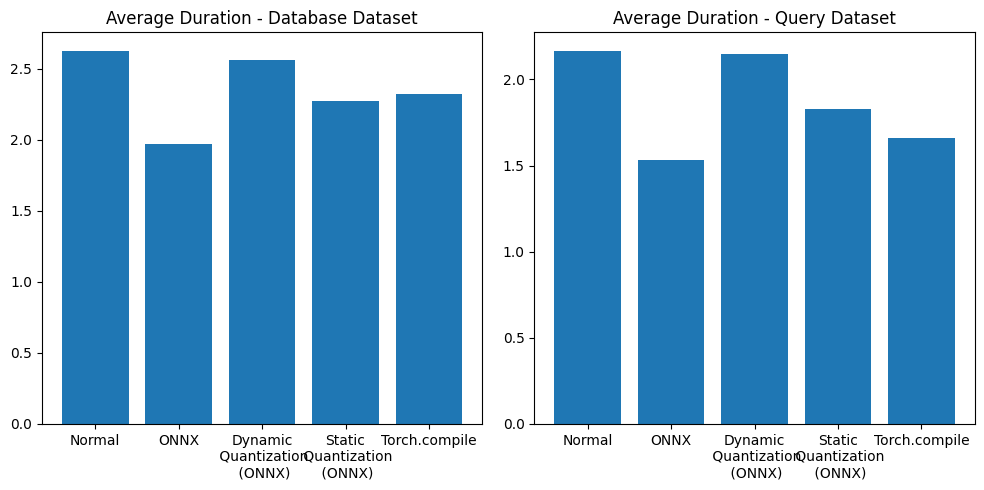

In [36]:
# Variables
models = ['Normal', 'ONNX', 'Dynamic\n Quantization\n (ONNX)', 'Static\n Quantization\n (ONNX)', 'Torch.compile']
db_avg_durations = [db_time, db_time_onnx, db_time_quant_dynamic, db_time_quant_static, db_time_torch_comp]
q_avg_durations = [q_time, q_time_onnx, q_time_quant_dynamic, q_time_quant_static, q_time_torch_comp]

# Create a figure
plt.figure(figsize=(10, 5))

# Create the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.bar(models, db_avg_durations)
plt.title('Average Duration - Database Dataset')

# Create the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.bar(models, q_avg_durations)
plt.title('Average Duration - Query Dataset')

# Show the plots
plt.tight_layout()
plt.show()

In [37]:
# # Convert the predictions to a numpy array
# bruh = db_features.detach().cpu().numpy()

# # Get the predicted labels (assuming a binary classification problem)
# predicted_labels = (bruh > 0.9).astype(int)

# # Get the ground truth labels
# true_labels = gt_data['GThard']

# # Get the predicted labels
# predicted_labels = bruh.argmax(axis=1)

# # Calculate the accuracy
# accuracy = (predicted_labels == true_labels).mean()
# print('Accuracy:', accuracy)

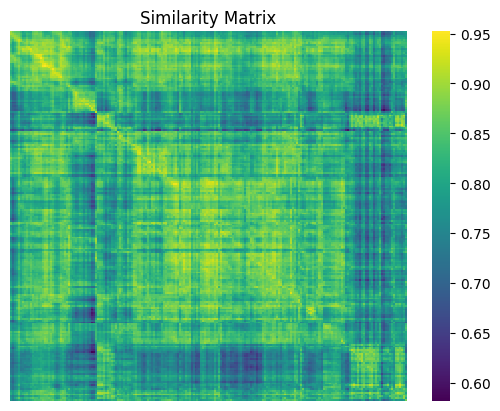

In [38]:
similarity_matrix = cosine_similarity(db_features.detach().numpy(), q_features.detach().numpy())

plt.figure()
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Similarity Matrix')
plt.axis('off')
plt.show()


Text(0.5, 1.0, 'Thresholding S>=thresh')

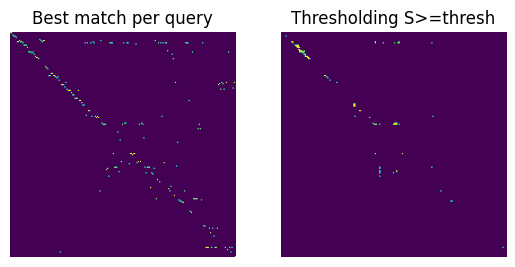

In [39]:
# best matching per query in S for single-best-match VPR
M1 = matching.best_match_per_query(similarity_matrix)

# find matches with S>=thresh using an auto-tuned threshold for multi-match VPR
M2 = matching.thresholding(similarity_matrix, 0.92)

# show M's
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(M1)
ax1.axis('off')
ax1.set_title('Best match per query')
ax2 = fig.add_subplot(122)
ax2.imshow(M2)
ax2.axis('off')
ax2.set_title('Thresholding S>=thresh')

In [40]:
TP = np.sum(M2 & gt_hard)  # true positives
FP = np.sum(M2 & ~gt_soft)  # false positives
FN = np.sum(gt_hard) - TP

# Calculate precision
precision = TP / (TP + FP)
print('Precision:', precision)

# # Calculate recall
recall = TP / (TP + FN)
print('Recall:', recall)

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print('F1 score:', f1)

Precision: 0.4727272727272727
Recall: 0.13
F1 score: 0.20392156862745098


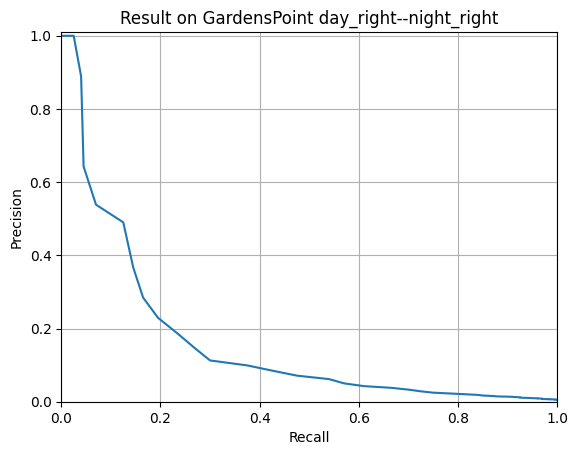

In [41]:
# precision-recall curve
P, R = createPR(similarity_matrix, gt_hard, gt_soft, matching='multi', n_thresh=100)
plt.figure()
plt.plot(R, P)
plt.xlim(0, 1), plt.ylim(0, 1.01)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Result on {DATASET} {DATABASE_FOLDER}--{QUERY_FOLDER}')
plt.grid('on')
plt.draw()
plt.show()

In [42]:
parameter_count = sum(p.numel() for p in calc.parameters())
print(f"Total Parameters: {parameter_count}")

memory_size = parameter_count * 4

for unit in ['KB', 'MB', 'GB']:
    if memory_size < 1024:
        print(f"Memory Size: {memory_size:.2f} {unit}")
        break
    memory_size /= 1024

Total Parameters: 137476
Memory Size: 537.02 MB


In [43]:
# Open the file in write mode
with open(DATA_TEXT_FILE, 'w') as f:
    # Write the database and query times to the file
    f.write(f"Database Average Time: {db_time}\n")
    f.write(f"Query Average Time: {q_time}\n")

    f.write(f"Database Average Time (ONNX): {db_time_onnx}\n")
    f.write(f"Query Average Time: {q_time_onnx}\n")

    f.write(f"Database Average Time (Dynamic Quantization): {db_time_quant_dynamic}\n")
    f.write(f"Query Average Time: {q_time_quant_dynamic}\n")

    f.write(f"Database Average Time (Static Quantization): {db_time_quant_static}\n")
    f.write(f"Query Average Time: {q_time_quant_static}\n")

    f.write(f"Database Average Time (Torch Compile): {db_time_torch_comp}\n")
    f.write(f"Query Average Time: {q_time_torch_comp}\n")

    f.write(f"Total Parameters: {parameter_count}\n")
    f.write(f"Memory Size: {memory_size}\n")